In [1]:
%matplotlib inline
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
#%load_ext autotime

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 10)
import numpy as np
import seaborn as sns

# EDA
## Load Data

In [2]:
Posts = pd.read_csv('../../../160-Stackoverflow-Data/300000_rows/Posts.csv', \
                    dtype = {'LastEditorDisplayName': str, 'Tags': str})

## Check NA of Posts

Text(0.5,1,'Posts NA')

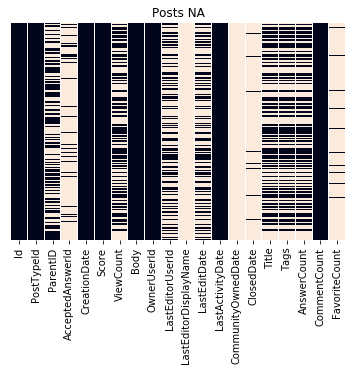

In [3]:
sns.heatmap(Posts.isnull(), yticklabels=False, cbar=False)
plt.title('Posts NA')

In [4]:
Posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299999 entries, 0 to 299998
Data columns (total 20 columns):
Id                       299999 non-null int64
PostTypeId               299999 non-null int64
ParentID                 152190 non-null float64
AcceptedAnswerId         41108 non-null float64
CreationDate             299999 non-null object
Score                    299999 non-null int64
ViewCount                147447 non-null float64
Body                     299813 non-null object
OwnerUserId              299597 non-null float64
LastEditorUserId         115234 non-null float64
LastEditorDisplayName    116 non-null object
LastEditDate             115344 non-null object
LastActivityDate         299999 non-null object
CommunityOwnedDate       239 non-null object
ClosedDate               10922 non-null object
Title                    147447 non-null object
Tags                     147447 non-null object
AnswerCount              147447 non-null float64
CommentCount             29999

# Timely Collaboration and Values
## Answers Posts

In [5]:
import datetime
import calendar

#date to timestamp
def date_ts(s):
    """ 
    param s: str - date
    returns: int - timestamp
    """
    date = datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    st = calendar.timegm(date.utctimetuple())
    return(st)

In [6]:
df_answers = Posts[Posts.PostTypeId == 2]

In [7]:
df_answers = df_answers.reset_index(drop=True)

In [8]:
df_answers.CreationDate = df_answers.CreationDate.str[:-4]

In [9]:
unix_ans = [date_ts(i) for i in df_answers.CreationDate]

In [10]:
df_answers_time = pd.DataFrame({'ParentID':df_answers.ParentID, 'Cr_time':unix_ans})

In [11]:
df_list = df_answers_time.groupby(df_answers_time.ParentID)

In [12]:
uni_par_id = list(df_answers_time.ParentID.unique())

In [13]:
ans_date = [list(df_list.get_group(i).Cr_time) for i in uni_par_id]

In [14]:
yes = 0
no = 0
for i in ans_date:
    if len(i) == 1:
        yes += 1
    else:
        no += 1
print(yes, no)

#there are 2917 posts with only 1 answer, 15773 posts with more than 1 answers.

87571 26874


In [15]:
#set 1-answer post sd to 0
for i in ans_date:
    if len(i) == 1:
        i.append(i[0])
    else:
        i == i

In [16]:
import statistics
ans_time_sd = [statistics.stdev(i) for i in ans_date]

In [17]:
post_Id = sorted(list(df_answers.ParentID.unique()))

In [18]:
post_ans_sd = pd.DataFrame({'post_Id':post_Id, 'time_sd':ans_time_sd})

In [19]:
post_ans_sd.head(10)

,post_Id,time_sd
0,1033.0,0.000000
1,2056.0,0.000000
2,2530.0,0.000000
3,4371.0,33.226495
4,5694.0,337954.962313
5,6414.0,0.000000
6,11345.0,0.000000
7,24853.0,0.000000
8,26733.0,0.000000
9,27509.0,136.469777


## Parents Posts

In [20]:
Parents_post = Posts[Posts.PostTypeId == 1]

In [21]:
Parents_post = Parents_post.reset_index(drop=True)

In [22]:
Parents_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147447 entries, 0 to 147446
Data columns (total 20 columns):
Id                       147447 non-null int64
PostTypeId               147447 non-null int64
ParentID                 0 non-null float64
AcceptedAnswerId         41108 non-null float64
CreationDate             147447 non-null object
Score                    147447 non-null int64
ViewCount                147447 non-null float64
Body                     147447 non-null object
OwnerUserId              147167 non-null float64
LastEditorUserId         73457 non-null float64
LastEditorDisplayName    82 non-null object
LastEditDate             73534 non-null object
LastActivityDate         147447 non-null object
CommunityOwnedDate       0 non-null object
ClosedDate               10922 non-null object
Title                    147447 non-null object
Tags                     147447 non-null object
AnswerCount              147447 non-null float64
CommentCount             147447 non-null

In [23]:
df_parents = pd.DataFrame({'post_Id':Parents_post.Id, 'Views_count':Parents_post.ViewCount,\
                           'Score':Parents_post.Score, 'Comment_count':Parents_post.CommentCount})

In [24]:
df_comb = df_parents.join(post_ans_sd.set_index('post_Id'), on='post_Id')

In [25]:
df_comb = df_comb.dropna()
df_comb = df_comb.reset_index(drop=True)

## Plots

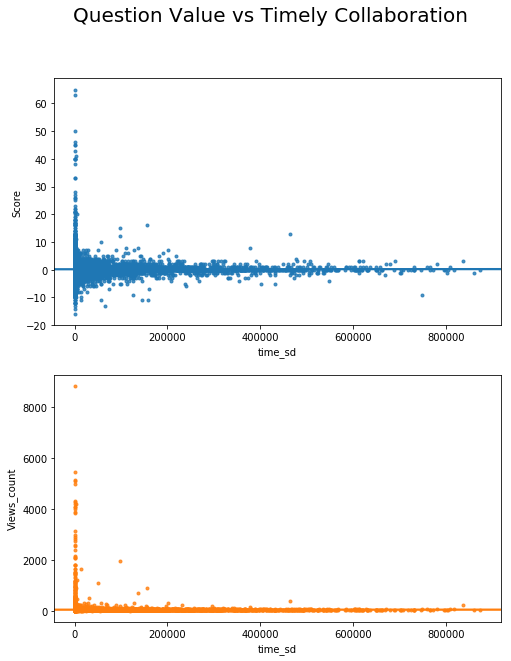

In [26]:
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,10))
plt.suptitle("Question Value vs Timely Collaboration", size=20)
sns.regplot(df_comb.time_sd, df_comb.Score, marker=".", ax=ax1)
sns.regplot(df_comb.time_sd, df_comb.Views_count, marker=".", ax=ax2)

## Data transformation

In [27]:
df_comb.head()

,Comment_count,Score,Views_count,post_Id,time_sd
0,0,1,50.0,48870881,22807.022120
1,0,0,27.0,48870882,2110.006635
2,2,0,27.0,48870886,229137.245336
3,0,1,17.0,48870888,0.000000
4,0,0,20.0,48870892,52159.731709


In [28]:
df_comb.Score.describe()

count    85059.000000
mean         0.190421
std          1.542484
min        -16.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         65.000000
Name: Score, dtype: float64

In [29]:
df_comb.Views_count.describe()

count    85059.000000
mean        38.351062
std         78.506050
min          3.000000
25%         23.000000
50%         32.000000
75%         44.000000
max       8821.000000
Name: Views_count, dtype: float64

In [30]:
import math
def loga(x):
    val = x+abs(min(df_comb.Score))+2
    out = 1/math.log10(val)
    return(out)

In [31]:
_min_score = abs(min(df_comb.Score)) + 2
_min_view = abs(min(df_comb.Views_count)) + 20
_min_view

23.0

In [32]:
View_log = df_comb.Views_count.apply(lambda x: 1/math.log10(x + _min_score))

In [33]:
Scores_log = df_comb.Score.apply(lambda x: 1/math.log10(x + _min_view))

In [34]:
yes = 0
no = 0
for i in df_comb.Score:
    if i < 0:
        yes += 1
    else:
        no += 1
print(yes, no)

12282 72777


## Plot of Transformed Data

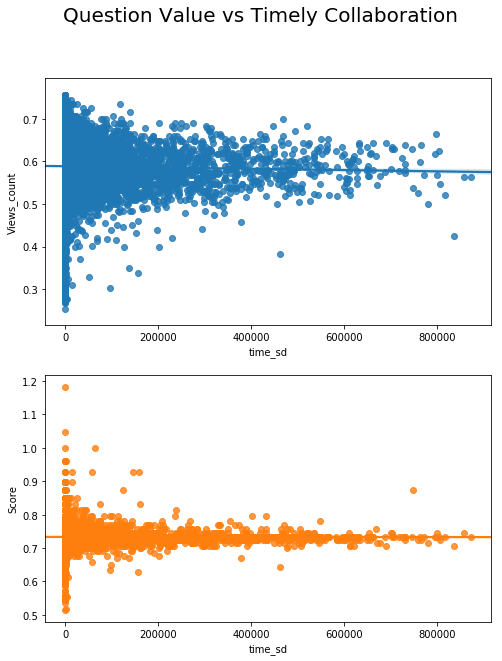

In [35]:
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,10))
plt.suptitle("Question Value vs Timely Collaboration", size=20)
sns.regplot(df_comb.time_sd, View_log, ax=ax1)
sns.regplot(df_comb.time_sd, Scores_log, ax=ax2)

## Linear Model Summary

In [36]:
from scipy import stats
import statsmodels.api as sm

/Users/esmondchu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [37]:
#Views
Views_model = sm.OLS(View_log, df_comb.time_sd)
Views_result = Views_model.fit()
#Score
Score_model = sm.OLS(Scores_log, df_comb.time_sd)
Score_result = Score_model.fit()

In [38]:
print(Views_result.summary())
print(Score_result.summary())

                            OLS Regression Results                            
Dep. Variable:            Views_count   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2125.
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        00:10:33   Log-Likelihood:                -74800.
No. Observations:               85059   AIC:                         1.496e+05
Df Residuals:                   85058   BIC:                         1.496e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
time_sd     2.328e-06   5.05e-08     46.097      0.0

# Probability of a question being answered as a function of time in minutes
eg. $P(\text{question is answered}|t=0,...,n , n=1,...,1440)$ for 

## Parents Post Data Wrangling

In [39]:
#Parents_post
df_answers.head()

,Id,PostTypeId,ParentID,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,48870883,2,48869547.0,NaN,2018-02-19T17:05:50,1,NaN,<p>Try to add hint to the query:</p>\r\n\r\n<p...,8214734.0,8214734.0,NaN,2018-02-20T10:20:21.007,2018-02-20T10:20:21.007,NaN,NaN,NaN,NaN,NaN,2,NaN
1,48870884,2,3865445.0,NaN,2018-02-19T17:05:50,0,NaN,In support of Sean's post:\r\n\r\n<p>The place...,2055283.0,NaN,NaN,NaN,2018-02-19T17:05:50.273,NaN,NaN,NaN,NaN,NaN,0,NaN
2,48870885,2,48870539.0,NaN,2018-02-19T17:05:51,0,NaN,<p>I discovered the convention (couldn't find ...,1052870.0,NaN,NaN,NaN,2018-02-19T17:05:51.300,NaN,NaN,NaN,NaN,NaN,1,NaN
3,48870889,2,48870709.0,NaN,2018-02-19T17:06:01,0,NaN,"<p>Group by the user, then aggregate a list of...",3182843.0,NaN,NaN,NaN,2018-02-19T17:06:01.910,NaN,NaN,NaN,NaN,NaN,0,NaN
4,48870891,2,48870253.0,NaN,2018-02-19T17:06:16,12,NaN,<p>With combination of <code>re.findall()</cod...,3185459.0,3185459.0,NaN,2018-02-19T17:13:55.730,2018-02-19T17:13:55.730,NaN,NaN,NaN,NaN,NaN,8,NaN


In [40]:
df_answers_time.head()

,Cr_time,ParentID
0,1519059950,48869547.0
1,1519059950,3865445.0
2,1519059951,48870539.0
3,1519059961,48870709.0
4,1519059976,48870253.0


In [41]:
parents_time = Parents_post.CreationDate.str[:-4]

In [42]:
unix_parents = [date_ts(i) for i in parents_time]

In [43]:
df_parents_time = pd.DataFrame({'Cr_time_parents':unix_parents, 'ParentID':Parents_post.Id})

In [44]:
df_parents_time.head()

,Cr_time_parents,ParentID
0,1519059948,48870881
1,1519059949,48870882
2,1519059952,48870886
3,1519059961,48870888
4,1519059966,48870890


## Merge Table & Create Columns of mins and hours

In [45]:
df_compare = pd.merge(df_parents_time, df_answers_time, on='ParentID')

In [46]:
df_compare.head()

,Cr_time_parents,ParentID,Cr_time
0,1519059948,48870881,1519060497
1,1519059948,48870881,1519061059
2,1519059949,48870882,1519060388
3,1519059949,48870882,1519060429
4,1519059952,48870886,1519060689


In [47]:
df_compare['Duration'] = df_compare.Cr_time - df_compare.Cr_time_parents

In [48]:
df_compare['Duration_mins'] = df_compare.Duration/60

In [49]:
df_compare['Duration_hours'] = df_compare.Duration_mins/60

In [50]:
df_compare.head()

,Cr_time_parents,ParentID,Cr_time,Duration,Duration_mins,Duration_hours
0,1519059948,48870881,1519060497,549,9.150000,0.152500
1,1519059948,48870881,1519061059,1111,18.516667,0.308611
2,1519059949,48870882,1519060388,439,7.316667,0.121944
3,1519059949,48870882,1519060429,480,8.000000,0.133333
4,1519059952,48870886,1519060689,737,12.283333,0.204722


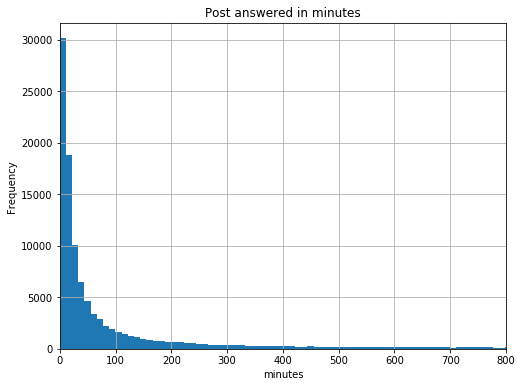

In [90]:
#Histogram
df_compare.Duration_mins.plot(kind = 'hist', bins=5000, figsize=(8,6))
plt.xlim(0,800)
plt.xlabel('minutes')
plt.title('Post answered in minutes')
plt.grid()

In [67]:
df_compare.Duration_mins.describe()

count    121385.000000
mean        609.633554
std        1971.848971
min           0.000000
25%          11.166667
50%          35.833333
75%         216.283333
max       55468.600000
Name: Duration_mins, dtype: float64

In [68]:
df_compare.Duration_hours.describe()

count    121385.000000
mean         10.160559
std          32.864150
min           0.000000
25%           0.186111
50%           0.597222
75%           3.604722
max         924.476667
Name: Duration_hours, dtype: float64

In [69]:
neg = 0
pos = 0
for i in df_compare.Duration_hours:
    if i >= 0:
        pos += 1
    else:
        neg += 1
print(pos, neg)

#15 negative duration, possibly an error from collecting data
#ie. negative duration means answer being posted before the parents questions being posted (not possible)

121385 0


In [70]:
df_compare.head()

,Cr_time_parents,ParentID,Cr_time,Duration,Duration_mins,Duration_hours
0,1519059948,48870881,1519060497,549,9.150000,0.152500
1,1519059948,48870881,1519061059,1111,18.516667,0.308611
2,1519059949,48870882,1519060388,439,7.316667,0.121944
3,1519059949,48870882,1519060429,480,8.000000,0.133333
4,1519059952,48870886,1519060689,737,12.283333,0.204722


## Calculate Frequency and Probability of mins and hours

In [71]:
Duration_mins_rounded = df_compare.Duration_mins.round()

In [72]:
fre_mins = pd.DataFrame(Duration_mins_rounded.value_counts(), index=None)
fre_mins['mins'] = fre_mins.index
fre_mins = fre_mins.rename(columns={'Duration_mins':'Frequency','mins':'mins'})
fre_mins.reset_index(inplace=True, drop=True)
#drop negative mins
fre_mins.drop(fre_mins[fre_mins.mins < 0].index, inplace=True)
fre_mins = fre_mins.sort_values('mins')

In [73]:
fre_mins.head()

,Frequency,mins
56,337,0.0
46,455,1.0
11,2027,2.0
5,3025,3.0
1,3583,4.0


In [74]:
fre_mins['Probabiity'] = fre_mins.Frequency/sum(fre_mins.Frequency)

In [75]:
fre_mins.head()

,Frequency,mins,Probabiity
56,337,0.0,0.002776
46,455,1.0,0.003748
11,2027,2.0,0.016699
5,3025,3.0,0.024921
1,3583,4.0,0.029518


In [76]:
fre_mins.Probabiity.describe()

count    7470.000000
mean        0.000134
std         0.001140
min         0.000008
25%         0.000008
50%         0.000016
75%         0.000033
max         0.029600
Name: Probabiity, dtype: float64

## Plot (Probability)

Text(0.5,1,'Probability of Answered in terms of Minutes')

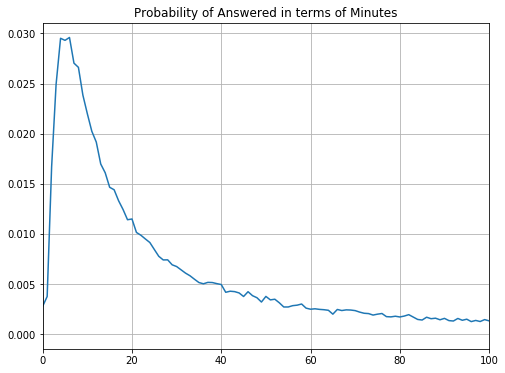

In [77]:
fig=plt.figure(figsize=(8,6))
plt.plot(fre_mins.mins, fre_mins.Probabiity)
plt.xlim(0,100)
plt.grid()
plt.title('Probability of Answered in terms of Minutes')

## Cumulative Probability 

In [78]:
fre_mins.head()

,Frequency,mins,Probabiity
56,337,0.0,0.002776
46,455,1.0,0.003748
11,2027,2.0,0.016699
5,3025,3.0,0.024921
1,3583,4.0,0.029518


In [79]:
fre_mins['cum_pro'] = np.cumsum(list(fre_mins.Probabiity))

In [80]:
fre_mins.head()

,Frequency,mins,Probabiity,cum_pro
56,337,0.0,0.002776,0.002776
46,455,1.0,0.003748,0.006525
11,2027,2.0,0.016699,0.023224
5,3025,3.0,0.024921,0.048144
1,3583,4.0,0.029518,0.077662


Text(0.5,0,'cumulative probability')

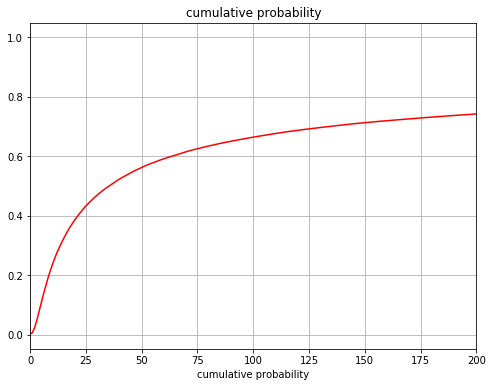

In [81]:
fig=plt.figure(figsize=(8,6))
plt.plot(fre_mins.mins, fre_mins.cum_pro, color='red')
plt.xlim(0,200)
plt.grid()
plt.title('cumulative probability')
plt.xlabel('cumulative probability')

## Summary of Probability Plots

Text(0.5,1,'cumulative probability')

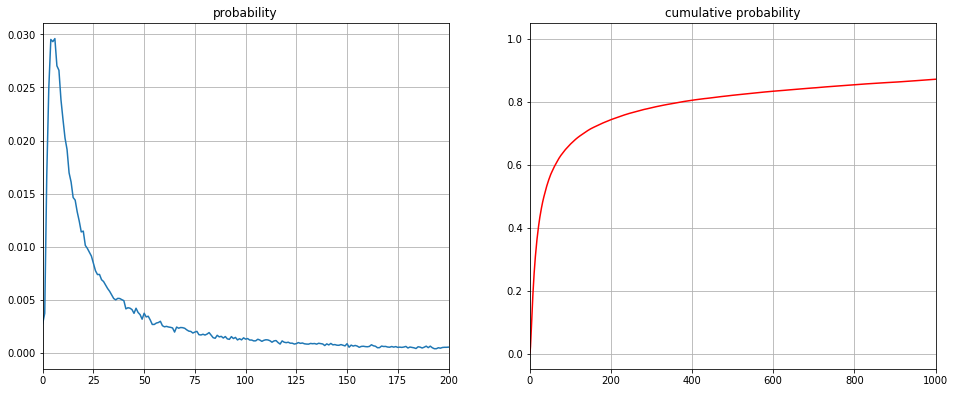

In [91]:
fig=plt.figure(figsize=(16,14))
plt.subplot(221)
plt.plot(fre_mins.mins, fre_mins.Probabiity)
plt.xlim(0,200)
plt.grid()
plt.title('probability')
plt.subplot(222)
plt.plot(fre_mins.mins, fre_mins.cum_pro, color='red')
plt.xlim(0,1000)
plt.grid()
plt.title('cumulative probability')

# Similarity

## Load Data

In [92]:
import json
with open('../../../160-Stackoverflow-Data/300000_rows/graph_dump_load.json',\
          'r') as json_file:
    data = json.load(json_file)

## Extract Content - Answers

In [93]:
#user id (asks list)
user_id_asks = [i for i in data if 'asks' in data[i].keys()]

In [94]:
#post id (asks list)
posts_id_asks = [data[i].get('asks') for i in data if 'asks' in data[i].keys()]

In [95]:
#user id (answers list)
user_id_answers = [i for i in data if 'answers' in data[i].keys()]

In [96]:
#post id (answers list)
posts_id_answers = [data[i].get('answers') for i in data if 'answers' in data[i].keys()]

## Extract Body

In [97]:
def get_body(x):
    return(list(Posts[Posts.Id == x].Body))

In [98]:
#asks text body
asks_body = [[get_body(posts_id_asks[j][i]) for i in range(len(posts_id_asks[j]))] for j in range(len(posts_id_asks))]

In [99]:
#answers text body
answers_body = [[get_body(posts_id_answers[j][i]) for i in range(len(posts_id_answers[j]))] for j in range(len(posts_id_answers))]

## NLP

In [ ]:
def flatten(word):
    """
    param word: str in a list of list
    return: str
    """
    word = list(itertools.chain.from_iterable(word))
    word = ' '.join(word)
    return(word)

In [88]:
import itertools
import re
import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize

# characters to replace by space (for html)
BRACKETS_RE = re.compile('[/(){}\[\]\|@,;]:') 
# insignificant words

STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['<p>','</p>','\r','</code></pre>','p','<','>','``',"''"])
def clean_and_tokenize_body(text):
    """
    @param text: str - raw string
    return: str - filtered, and tokenized string
    """
    text = re.sub(BRACKETS_RE, ' ', text.lower())
    return ' '.join([w for w in word_tokenize(text) if not w in STOPWORDS])

## Calculating Similarity 

Dan takes over this parts, potential matrix run time being too long.

# Topical Strength

## Functions

In [89]:
TagSyn = pd.read_csv("../../../160-Stackoverflow-Data/tags/TagSynonyms.csv")
tagcols = pd.DataFrame(TagSyn.SourceTagName.values,TagSyn.TargetTagName,columns=['values'])

In [90]:
#Borrow Seungmi Functions
def answers_user(user_id):
    """tags of 'question' posts that the user posted 'answers' to, 
    and count the number of the user's answers for each tag
    
    @param user_id: int 
    return: series 
    """
    filtered = []
    pattern = '[<>]'
    regex = re.compile(pattern, flags = re.IGNORECASE)
    answers_id = list(Posts.loc[(Posts.OwnerUserId == user_id) &  (Posts.PostTypeId == 2)]['ParentID'])

    for i in range(len(answers_id)):
        tags = Posts.loc[(Posts.Id == answers_id[i])]['Tags'] #extracting tags from its parent post
        
        try:
            tags1 = list(filter(None,regex.split(tags.iloc[0]))) 
            for i in range(len(tagcols)):
                if tagcols['values'][i] in tags1:
                    tags1[tags1.index(tagcols['values'][i])] = tagcols.index[i] #mapping tags to their simpliest reduction
            filtered.extend(tags1)
        except:
            continue
    freq_answers = pd.DataFrame({'Tag':filtered}).groupby('Tag').size()
    return freq_answers

In [91]:
#Borrow Seungmi Functions
def accepted_ans(user_id):
    """tags of 'question' posts that the user's answer was accepted to('AcceptedAnswer'), 
    and count the number of the user's accepted answers for each tag
    
    @param user_id: int 
    return: series 
    """
    accepted_tags = []
    pattern = '[<>]'

    regex = re.compile(pattern, flags = re.IGNORECASE)
    answers = Posts.loc[(Posts.OwnerUserId == user_id) &  (Posts.PostTypeId == 2)]

    for i in range(len(answers)):
        tags = Posts.loc[(Posts.AcceptedAnswerId == answers.Id.iloc[i])]['Tags']
        try:
            tags1 = list(filter(None,regex.split(tags.iloc[0]))) 
            for i in range(len(tagcols)):
                if tagcols['values'][i] in tags1:
                    #mapping tags to their simpliest reduction
                    tags1[tags1.index(tagcols['values'][i])] = tagcols.index[i] 
            accepted_tags.extend(tags1)
        except:
            continue
    freq_acanswers = pd.DataFrame({'Tag':accepted_tags}).groupby('Tag').size()
    return freq_acanswers

In [92]:
Comments = pd.read_csv('/Users/esmondchu/Dropbox/UC_Davis/STAT/STA160Spring18/160-Stackoverflow-Data/300000_rows/Comments.csv')

In [93]:
#Borrow Seungmi Functions
import re
def comments_user(user_id):
    """tags of 'question' posts that the user posted 'comments' to, 
    and count the number of the user's comments for each tag
    
    @param user_id: int 
    return: series 
    """
    comments_tags = []
    pattern = '[<>]'


    regex = re.compile(pattern, flags = re.IGNORECASE)
    comments = Comments.loc[(Comments.UserId == user_id)]['PostId']

    for i in range(len(comments)):
        tags = Posts.loc[(Posts.Id == comments.iloc[i])]['Tags']
        try:
            tags1 = list(filter(None,regex.split(tags.iloc[0]))) 
            for i in range(len(tagcols)):
                if tagcols['values'][i] in tags1:
                    tags1[tags1.index(tagcols['values'][i])] = tagcols.index[i] #mapping tags to their simpliest reduction
            comments_tags.extend(tags1)
        except:
            continue
    freq_comments = pd.DataFrame({'Tag':comments_tags}).groupby('Tag').size()
    return freq_comments

In [94]:
#Borrow Seungmi Functions
def activities(user_id):
    """the number of activities such as answers, accepted answers and comments of the user for each tag
    
    @param user_id: int 
    return: dataframe
    """
    answers = answers_user(user_id)
    acc_answers = accepted_ans(user_id)
    comments = comments_user(user_id)
    user_table = pd.DataFrame({'Answers' : answers ,'Accepted Answers' : acc_answers , 'Comments': comments})
    user_table = user_table.fillna(0)
    if len(user_table) != 0 :
        user_table['Total'] = user_table.apply(lambda row: (row['Answers'])+(row['Accepted Answers'])+(row['Comments']), axis=1)
        
    return user_table

## Number of activities for a tags for a user vs max of this users

In [95]:
#unique users list
users_unique = list(Posts[Posts.PostTypeId == 2].OwnerUserId.unique())

In [96]:
with open('../../../160-Stackoverflow-Data/tags/all_unique_tags.txt', 'r') as f:
    tags_unique = f.readlines()

In [ ]:
#unique tags list
tags_unique = [i.rstrip() for i in tags_unique]

In [ ]:
#try not to attempt to run
#outcome is a list with ~len(tags_unique)*len(users_unique)
big_list = []
for tags in tags_unique:
    for users in users_unique:
        if tags in activities(users).index:
            spe_tags = {tags:{users:activities(users).loc[tags][3]}}
            big_list.append(spe_tags)
        else:
            big_list = big_list
max_users = max(big_list)
users_tags_ratio = [i/max_users for i in big_list]

In [ ]:
#subset version
#still takes long time to run
def topical_strength(tags):
    """
    arguments:
        tags (str): the target tags
    returns:
        list: a list with ratio of activities counts of each users/ max of the list for the input tag
    """
    tags_users = []
    for users in users_unique:
        if tags in activities(users).index:
            spe_tags = {tags:{users:activities(users).loc[tags][3]}}
            tags_users.append(spe_tags)
        else:
            tags_users = tags_users
    max_users = max(tags_users)
    users_tags_ratio = [i/max_users for i in tags_users]
    return(users_tags_ratio)

# Sandbox

In [ ]:
TagSyn_sub = pd.DataFrame({'Source':TagSyn.SourceTagName,'Target':TagSyn.TargetTagName})

In [ ]:
#transformation to target tags
def tags_syn(input_set):
    """change tags to target tag
    
    argument:
        input_set - list, the list of input tags
    returns:
        list - the list with transformed target tags
    """
    for i in range(len(TagSyn_sub)):
        if TagSyn_sub.Source[i] in input_set:
            input_set[input_set.index(TagSyn_sub.Source[i])] = TagSyn_sub.Target[i]
    return(input_set)